In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#Training algorithms import
import xgboost as xgb 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



plt.style.use("fivethirtyeight")

# Evaluation and training imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [7]:
df = pd.read_csv("..\data\datalog_1.csv", parse_dates=True, header=None) #, index_col="Datetime"
df.columns = ["Datetime","Temperature", "Humidity" , "Pressure", "Altitude" ,"CO" ,"CO2" ,"NH4", "PM1.0" ,"PM2.5", "PM10.0"]
df['Datetime'] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d %H:%M:%S')

quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
                  'PM$_{2.5}$', 'PM$_{10}$']
units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ']
df = df.set_index("Datetime")
df['Pressure'] = df['Pressure']/100

## For PM1.0

In [8]:
# Adding an hour feature to the dataset 
df["hour"] = df.index.hour

<AxesSubplot: title={'center': 'Particulate Matter 1.0 [$\\mu g/m^3$ ]'}, xlabel='Datetime'>

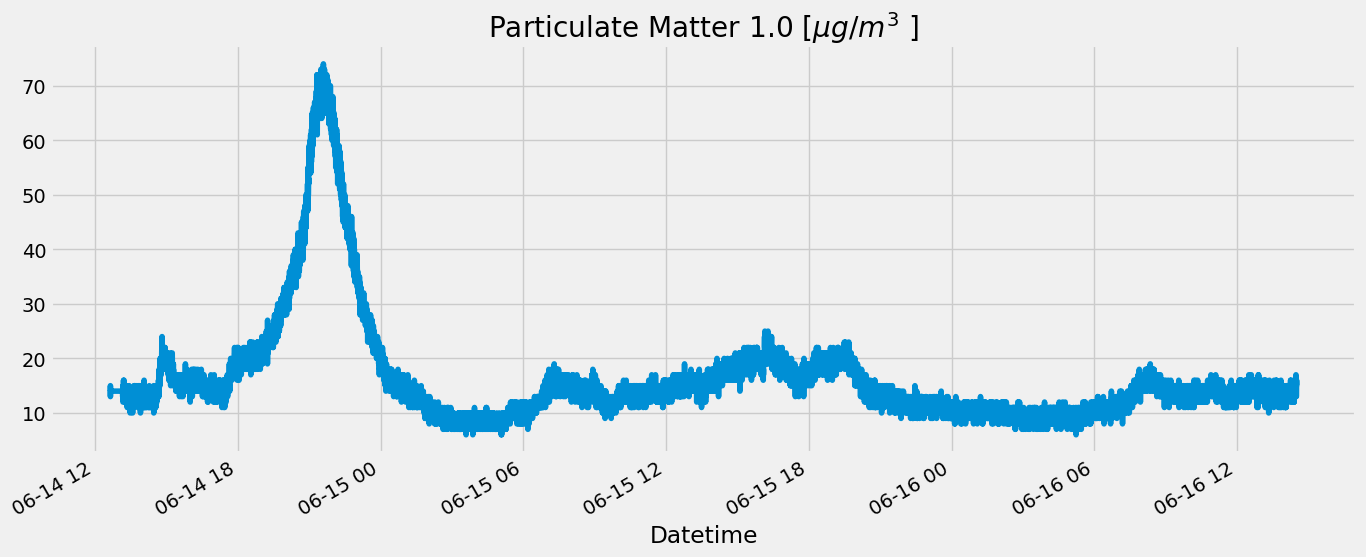

In [9]:
df["PM1.0"].plot(figsize=(15, 6), title=f"Particulate Matter 1.0 [{units[6]}]")

## Model Creation


### Train/ Test Split


In [10]:
#Splitting of train and test data
X = df.drop("PM1.0", axis=1)
y = df["PM1.0"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## XGBoost Linear Regression

In [11]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             verbose=100)

[0]	validation_0-rmse:18.77264	validation_1-rmse:18.02795
[100]	validation_0-rmse:6.96538	validation_1-rmse:6.69671
[200]	validation_0-rmse:2.71259	validation_1-rmse:2.63237
[300]	validation_0-rmse:1.30982	validation_1-rmse:1.31531
[400]	validation_0-rmse:0.94734	validation_1-rmse:0.99744
[500]	validation_0-rmse:0.87075	validation_1-rmse:0.94084
[600]	validation_0-rmse:0.84755	validation_1-rmse:0.92987
[700]	validation_0-rmse:0.83845	validation_1-rmse:0.92796
[800]	validation_0-rmse:0.83187	validation_1-rmse:0.92678
[900]	validation_0-rmse:0.82610	validation_1-rmse:0.92560
[999]	validation_0-rmse:0.82008	validation_1-rmse:0.92407


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [12]:
pm1_0_model = joblib.dump(xgb_model, "trained/xgb_pm1.sav")

 ### Feature Importance

In [13]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=["importance"])

<AxesSubplot: title={'center': 'Feature Importance'}>

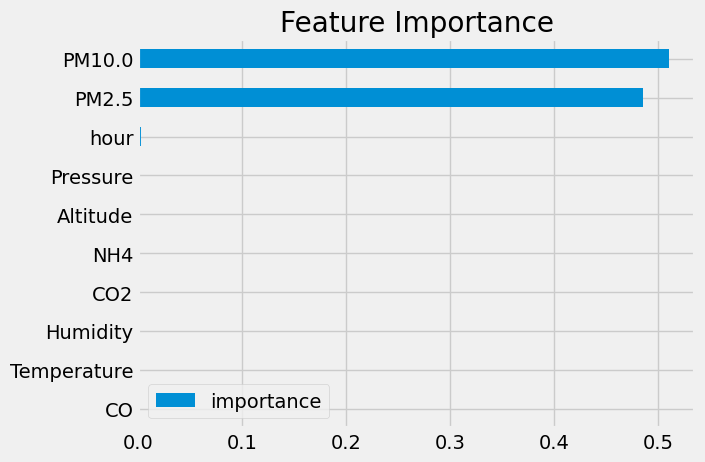

In [14]:
fi.sort_values('importance').plot(kind="barh", title="Feature Importance")

### Forecast on Test

In [15]:
# Forecasting previous values to see the performance of model
xgb_prediction = xgb_model.predict(X)
df["xgbpredict"] = xgb_prediction

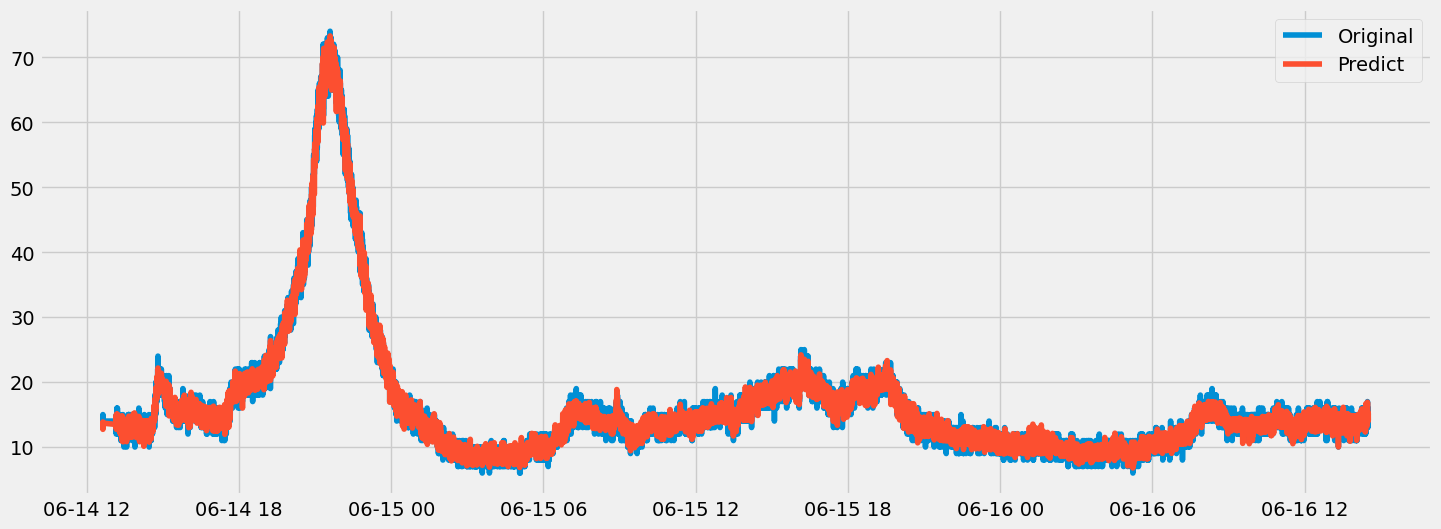

In [16]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["xgbpredict"], label="Predict")


ax.legend()

### Evaluation Metric

In [17]:
#  Mean Squared Error
xgb_mse = mean_squared_error(df["PM1.0"], df["xgbpredict"])
xgb_mse

0.6997779415091193

In [18]:
#Root Mean Squared Error
xgb_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["xgbpredict"]))
xgb_rmse

0.8365273106773737

In [19]:
# Mean Absolute Error
xgb_mae = mean_absolute_error(df["PM1.0"], df["xgbpredict"])
xgb_mae

0.6605355222854297

In [20]:
xgb_err_eval = [xgb_mse, xgb_rmse, xgb_mae]
xgb_err_eval

[0.6997779415091193, 0.8365273106773737, 0.6605355222854297]

## Sklearn Linear Regression 

In [21]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)



LinearRegression()

In [22]:
linreg_model_sav = joblib.dump(linreg_model, "trained/linreg_pm1.sav")

### Forecast on Test

In [23]:
# Forecasting previous values to see the performance of model
linreg_prediction = linreg_model.predict(X)
df["linregpredict"] = linreg_prediction

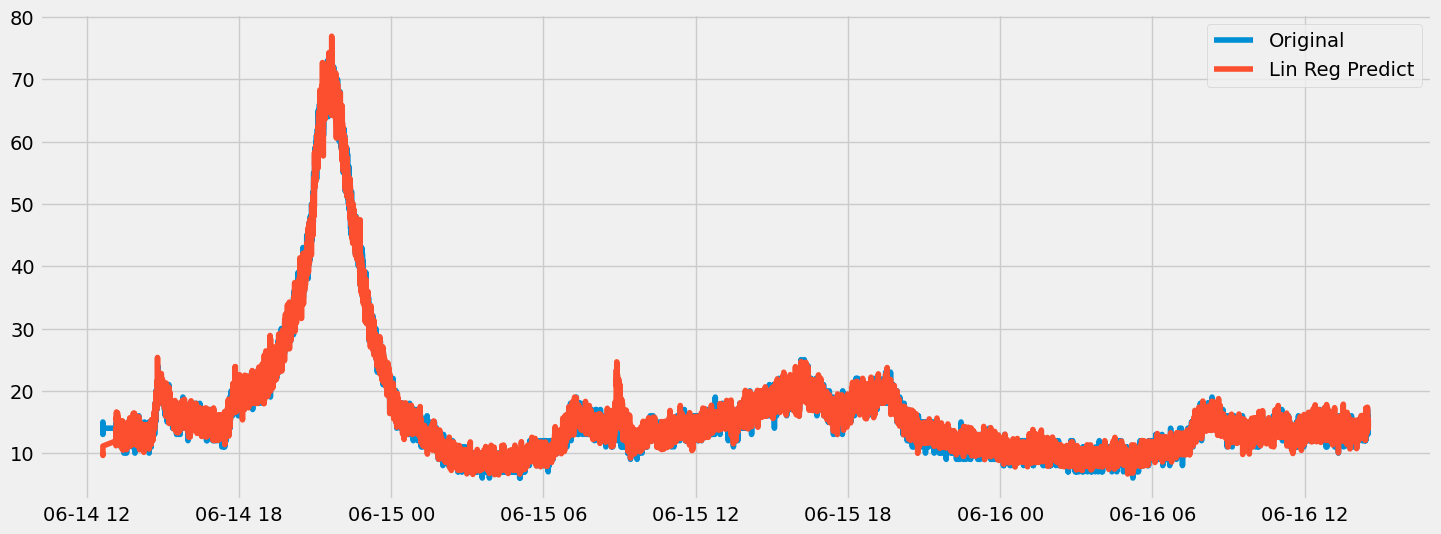

In [24]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["linregpredict"], label="Lin Reg Predict")


ax.legend()

### Evaluation Metric

In [25]:
#  Mean Squared Error
linreg_mse = mean_squared_error(df["PM1.0"], df["linregpredict"])
linreg_mse

1.1658654265607202

In [26]:
#Root Mean Squared Error
linreg_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["linregpredict"]))
linreg_rmse

1.0797524839335728

In [27]:
# Mean Absolute Error
linreg_mae = mean_absolute_error(df["PM1.0"], df["linregpredict"])
linreg_mae

0.8231328064956723

In [28]:
linreg_err_eval = [linreg_mse, linreg_rmse, linreg_mae]
linreg_err_eval

[1.1658654265607202, 1.0797524839335728, 0.8231328064956723]

## Sklearn  Decision Tree Classifier

In [29]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)


DecisionTreeClassifier()

In [30]:
tree_model_sav = joblib.dump(tree_model, "trained/tree_pm1.sav")

### Forecast on Test

In [31]:
# Forecasting previous values to see the performance of model
tree_model_prediction = tree_model.predict(X)
df["treepredict"] = tree_model_prediction

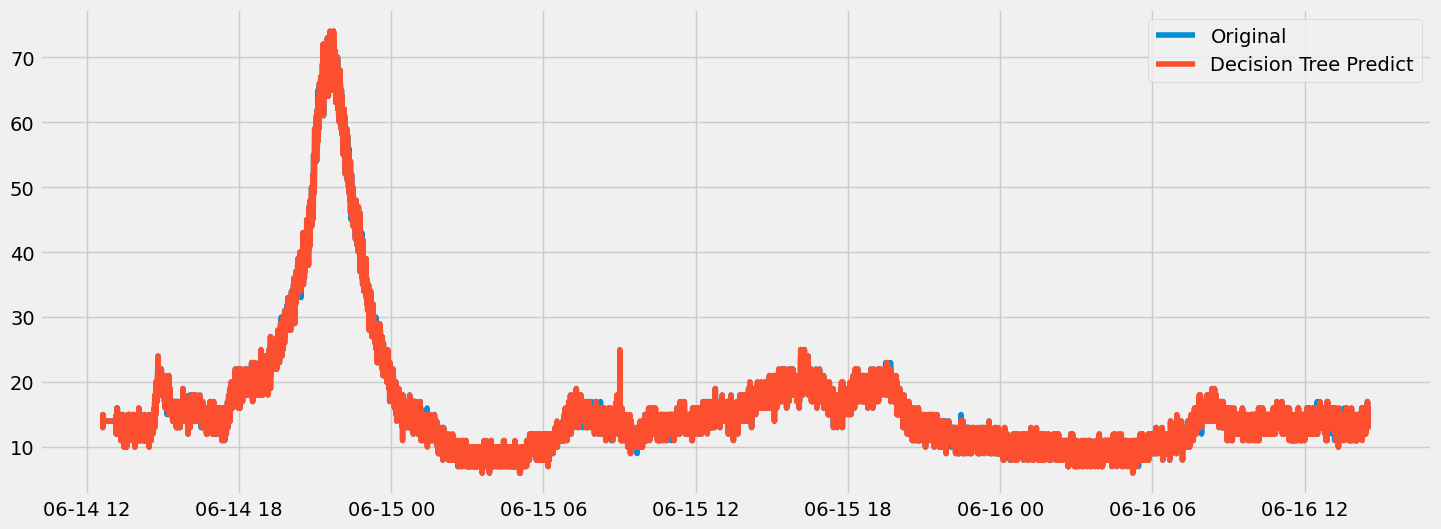

In [32]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["treepredict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [33]:
#  Mean Squared Error
tree_model_mse = mean_squared_error(df["PM1.0"], df["treepredict"])
tree_model_mse

0.24746179330982152

In [34]:
#Root Mean Squared Error
tree_model_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["treepredict"]))
tree_model_rmse

0.4974553179028459

In [35]:
# Mean Absolute Error
tree_model_mae = mean_absolute_error(df["PM1.0"], df["treepredict"])
tree_model_mae

0.13674254568772043

In [36]:
tree_err_eval = [tree_model_mse, tree_model_rmse, tree_model_mae]
tree_err_eval

[0.24746179330982152, 0.4974553179028459, 0.13674254568772043]

## Sklearn  Decision Tree Regressor

In [37]:
tree_reg_model = DecisionTreeRegressor()
tree_reg_model.fit(X_train, y_train)



DecisionTreeRegressor()

In [38]:
tree_reg_model_sav = joblib.dump(tree_model, "trained/tree_reg_pm1.sav")

### Forecast on Test

In [39]:
# Forecasting previous values to see the performance of model
tree_reg_prediction = tree_reg_model.predict(X)
df["tree_reg_predict"] = tree_reg_prediction

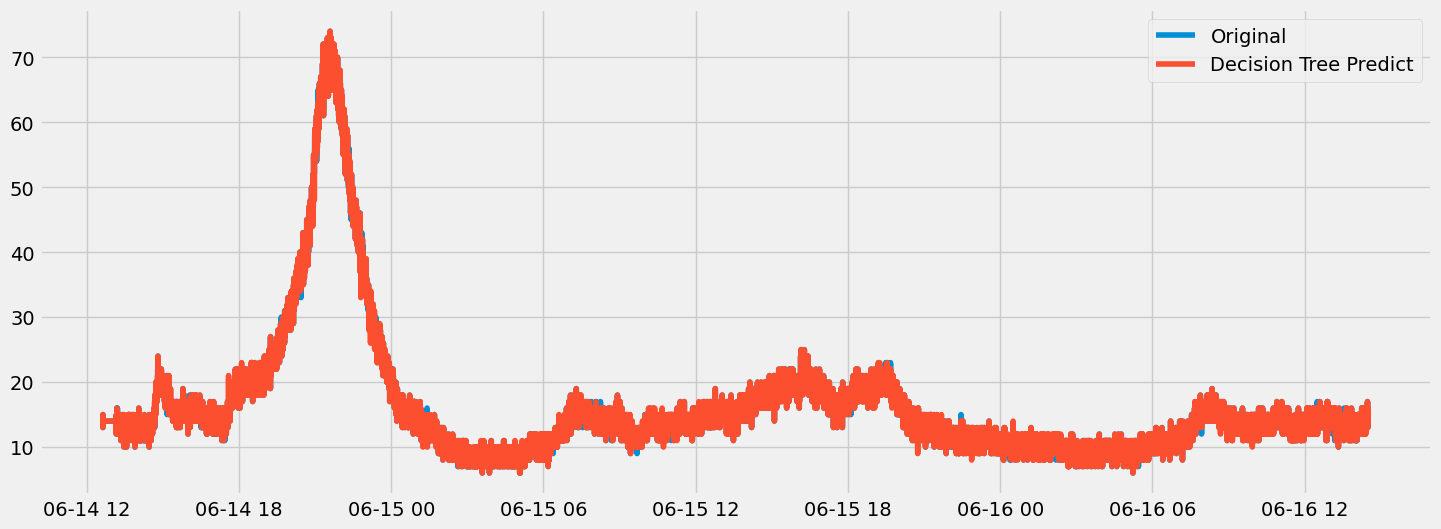

In [40]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["tree_reg_predict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [41]:
#  Mean Squared Error
tree_reg_model_mse = mean_squared_error(df["PM1.0"], df["tree_reg_predict"])
tree_reg_model_mse

0.23383563107833708

In [42]:
#Root Mean Squared Error
tree_reg_model_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["tree_reg_predict"]))
tree_reg_model_rmse

0.4835655395893478

In [43]:
# Mean Absolute Error
tree_reg_model_mae = mean_absolute_error(df["PM1.0"], df["tree_reg_predict"])
tree_reg_model_mae

0.13540664742973174

In [44]:
tree_reg_err_eval = [tree_reg_model_mse, tree_reg_model_rmse, tree_reg_model_mae]
tree_reg_err_eval

[0.23383563107833708, 0.4835655395893478, 0.13540664742973174]

## Sklearn RandomForest Classifier

In [45]:
rforest_model = RandomForestClassifier()
rforest_model.fit(X_train, y_train)



RandomForestClassifier()

In [46]:
rforest_model_sav = joblib.dump(rforest_model, "trained/rforest_pm1.sav")

### Forecast on Test

In [47]:
# Forecasting previous values to see the performance of model
rforest_prediction = rforest_model.predict(X)
df["rforestpredict"] = rforest_prediction

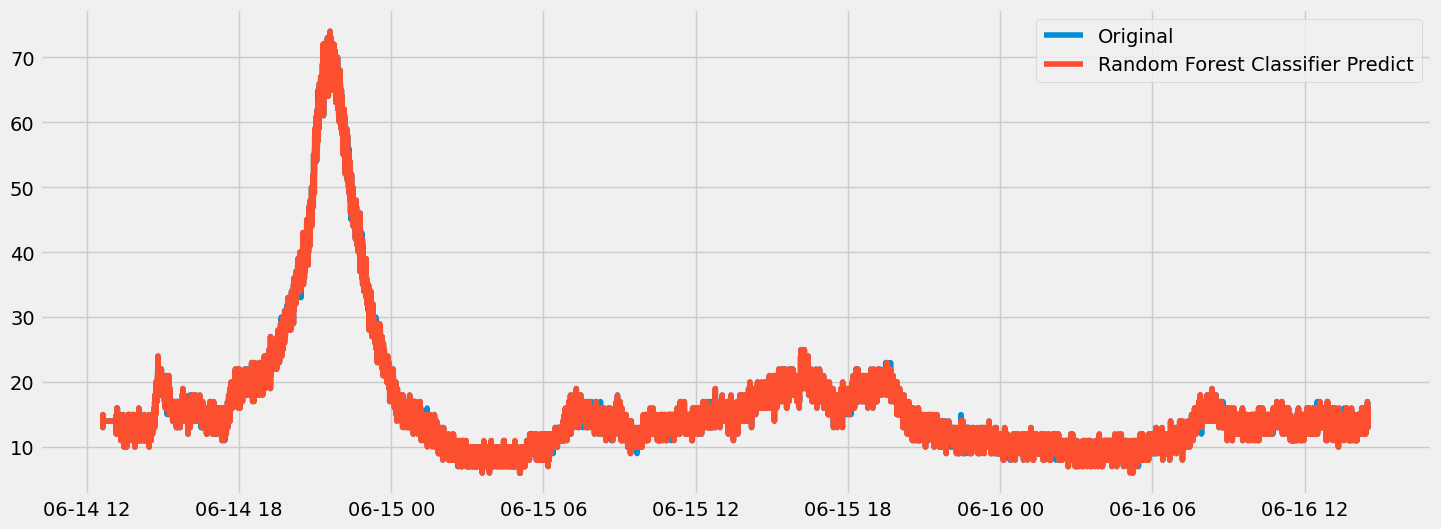

In [48]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["rforestpredict"], label="Random Forest Classifier Predict")


ax.legend()

### Evaluation Metric

In [49]:
#  Mean Squared Error
rforest_mse = mean_squared_error(df["PM1.0"], df["rforestpredict"])
rforest_mse

0.17099497702254995

In [50]:
#Root Mean Squared Error
rforest_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["rforestpredict"]))
rforest_rmse

0.4135153891000309

In [51]:
# Mean Absolute Error
rforest_mae = mean_absolute_error(df["PM1.0"], df["rforestpredict"])
rforest_mae

0.1123223255316875

In [52]:
rforest_err_eval = [rforest_mse, rforest_rmse, rforest_mae]
rforest_err_eval

[0.17099497702254995, 0.4135153891000309, 0.1123223255316875]

## Sklearn RandomForest Regressor

In [53]:
rforest_reg_model = RandomForestRegressor()
rforest_reg_model.fit(X_train, y_train)



RandomForestRegressor()

In [54]:
rforest_reg_model_sav = joblib.dump(rforest_reg_model, "trained/rforest_reg_pm1.sav")

### Forecast on Test

In [55]:
# Forecasting previous values to see the performance of model
rforest_reg_prediction = rforest_model.predict(X)
df["rforest_reg_predict"] = rforest_reg_prediction

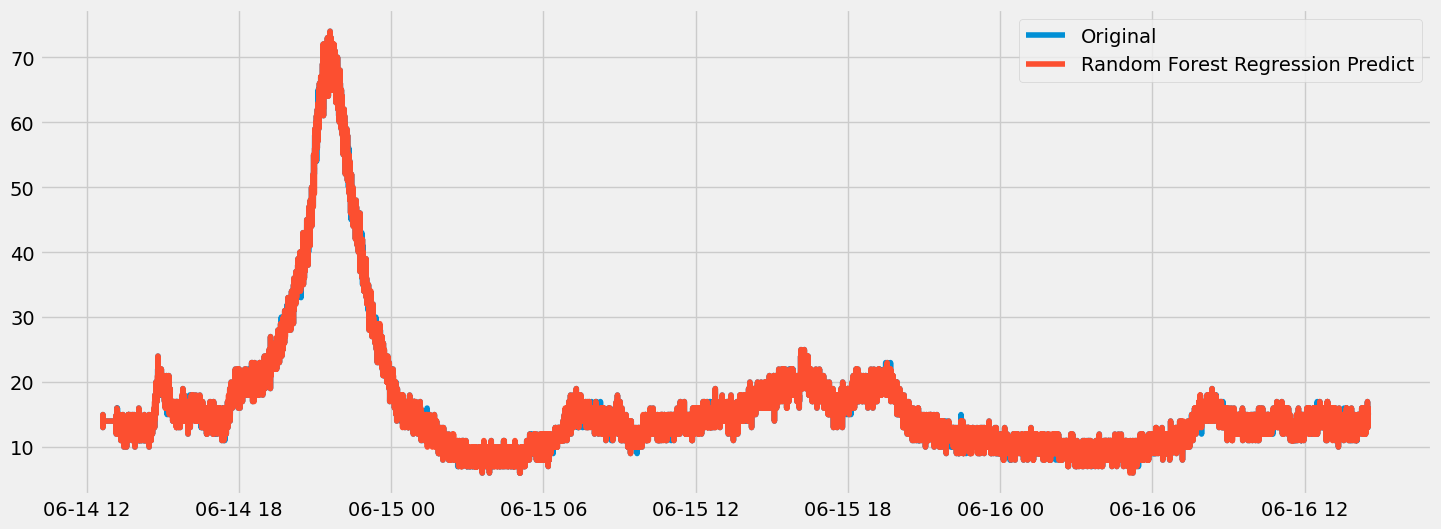

In [56]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["rforest_reg_predict"], label="Random Forest Regression Predict")


ax.legend()

### Evaluation Metric

In [57]:
#  Mean Squared Error
rforest_reg_mse = mean_squared_error(df["PM1.0"], df["rforest_reg_predict"])
rforest_reg_mse

0.17099497702254995

In [58]:
#Root Mean Squared Error
rforest_reg_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["rforest_reg_predict"]))
rforest_reg_rmse

0.4135153891000309

In [59]:
# Mean Absolute Error
rforest_reg_mae = mean_absolute_error(df["PM1.0"], df["rforest_reg_predict"])
rforest_reg_mae

0.1123223255316875

In [60]:
rforest_reg_err_eval = [rforest_reg_mse, rforest_reg_rmse, rforest_reg_mae]
rforest_reg_err_eval

[0.17099497702254995, 0.4135153891000309, 0.1123223255316875]

## Overall Minimum Error Evaluation of Models

In [61]:
# error_evals = [xgb_err_eval,
#                 linreg_err_eval,
#                 tree_err_eval,
#                 tree_reg_err_eval,
#                 rforest_err_eval,
#                 rforest_reg_err_eval]


error_evals = {"Xgb Reg": xgb_err_eval,
            "Linear Reg": linreg_err_eval,
            "DecisionTreeClassifier": tree_err_eval,
            "DecisionTreeRegressor": tree_reg_err_eval,
            "RandomForestClassifier": rforest_err_eval,
            "RandomForestRegressor": rforest_reg_err_eval}

error_evals

{'Xgb Reg': [0.6997779415091193, 0.8365273106773737, 0.6605355222854297],
 'Linear Reg': [1.1658654265607202, 1.0797524839335728, 0.8231328064956723],
 'DecisionTreeClassifier': [0.24746179330982152,
  0.4974553179028459,
  0.13674254568772043],
 'DecisionTreeRegressor': [0.23383563107833708,
  0.4835655395893478,
  0.13540664742973174],
 'RandomForestClassifier': [0.17099497702254995,
  0.4135153891000309,
  0.1123223255316875],
 'RandomForestRegressor': [0.17099497702254995,
  0.4135153891000309,
  0.1123223255316875]}

In [62]:
# Finding the lowest error evaluations for trained models
def comp_val(sublist):
    return sublist[0]

min_error = min(error_evals, key=lambda key: comp_val(error_evals[key]))
print(f"Lowest error evaluation for trained models was {min_error}")

Lowest error evaluation for trained models was RandomForestClassifier
